In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import nn
from torch import optim
try: 
    import torchbearer
except:
    !pip install torchbearer
from torchbearer import Trial


In [11]:
class CustomData(Dataset):
    def __init__(self):
        self.samples = list(range(1, 10))
  
    def __len__(self):
        return len(self.samples)
  
    def __getitem__(self, index):
        return self.samples[index]

c_data = CustomData()
len(c_data), c_data[2]
            

(9, 3)

In [6]:

class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10,10,(1,),dtype=torch.float)
            dy = torch.randint(-10,10,(1,),dtype=torch.float)
            c = torch.randint(-20,20,(1,), dtype=torch.float)

            params = torch.cat((dy/dx, c))
            xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
            xy[:,1] = xy[:,0] * params[0] + params[1]

            xy.round_()
            xy = xy[ xy[:,1] > 0 ]
            xy = xy[ xy[:,1] < self.dim ]
            xy = xy[ xy[:,0] < self.dim ]

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)]=1

            if img.sum() > 2:
                break

        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)


In [10]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


# Visulize the Image

In [8]:
len(val_data), val_data[120], val_data[120][0].shape

(500, (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  tensor([  0.9000, -10.0000])), torch.Size([1, 40, 40]))

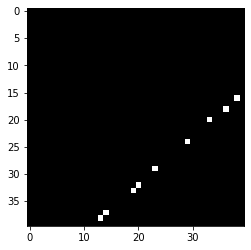

In [9]:
import matplotlib.pyplot as plt
plt.imshow(val_data[120][0][0], cmap=plt.get_cmap('gray'))


In [11]:
# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)


# Simple CNN

In [101]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48*40**2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [102]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 17.70989227294922}


# Pooling

In [13]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x): # 1,40,40
        out = self.conv1(x) 
        out = F.relu(out) # 48,40,40
        out = self.conv2(out) # 48,40,40 
        out = F.relu(out)
        
        out = F.adaptive_max_pool2d(out, (1,1)) # 48,1,1
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [14]:
# build the model
model = BetterCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 15.119308471679688}


# Add Channel

## Visualize Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


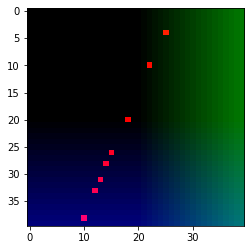

In [37]:
for data in trainloader:
    x, labels = data
    idxx = torch.repeat_interleave(
    torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0).to(x.device)
    idxy = idxx.clone().t()
    idx = torch.stack([idxx, idxy]).unsqueeze(0)
    idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0) 
    x = torch.cat([x, idx], dim=1)
    plt.imshow(x[0].permute(1, 2, 0)  )
    break

In [40]:
class BestCNN(nn.Module):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x): # 1,40,40
        idxx = torch.repeat_interleave(
        torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0) 
        x = torch.cat([x, idx], dim=1)

        out = self.conv1(x) 
        out = F.relu(out) # 48,40,40
        out = self.conv2(out) # 48,40,40 
        out = F.relu(out)
        
        out = F.adaptive_max_pool2d(out, (1,1)) # 48,1,1
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [41]:
# build the model
model = BestCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 1.0357235670089722}
